# Llama Lend Partial Liquidation Example
Adapted from [@Macket](https://x.com/Macket7)'s Liquidation Demo [@curvefi/liquidation-demo](https://github.com/curvefi/liquidation-demo/)

In [1]:
import boa, os, time
import matplotlib.pyplot as plt
import matplotlib
import pandas as pd
import numpy as np

from IPython.display import Math, display
from dotenv import load_dotenv
from boa.explorer import fetch_abi_from_etherscan
from boa.contracts.abi.abi_contract import ABIContractFactory

%reload_ext boa.ipython

# Onchain Addresses
FACTORY_ADDR = "0xeA6876DDE9e3467564acBeE1Ed5bac88783205E0"
CRVUSD_ADDR = "0xf939E0A03FB07F59A73314E73794Be0E57ac1b4E"
WBTC_ADDR = "0x2260FAC5E5542a773Aa44fBCfeDf7C193bc2C599"

# Environment Variables
load_dotenv(".env")
ETHERSCAN_API = "https://api.etherscan.io/api"
ETHERSCAN_KEY = os.getenv("ETHERSCAN_KEY") 
RPC_URL = "https://eth-mainnet.g.alchemy.com/v2/" + os.getenv("ALCHEMY_KEY")
boa.env.fork(RPC_URL)

In [2]:
# Create Users
ADMIN = boa.env.generate_address()
BORROWER = boa.env.generate_address()
TRADER = boa.env.generate_address()
LIQUIDATOR = boa.env.generate_address()

print(f"ADMIN:\t\t{ADMIN}\n\
BORROWER:\t{BORROWER}\n\
TRADER:\t\t{TRADER}\n\
LIQUIDATOR:\t{LIQUIDATOR}")

ADMIN:		0xd13f0Bd22AFF8176761AEFBfC052a7490bDe268E
BORROWER:	0xA73d7cddCf77c00827459f986bf828999B58C6Fe
TRADER:		0x1fb0aF040B7bbA2A6f69e77DA9C0dCb7785b3A3B
LIQUIDATOR:	0x93f00b06693262b2A06a66F643e38B89FB2A7118


In [3]:
# Helper Functions
SLEEP_DELAY = 1

def load_from_impl(contract_addr, abi_addr, name='Unnamed'):
    abi = fetch_abi_from_etherscan(abi_addr, ETHERSCAN_API, ETHERSCAN_KEY)
    time.sleep(SLEEP_DELAY)
    return ABIContractFactory.from_abi_dict(abi, name=name).at(contract_addr)


def plot_results(trade_data):
    # Assuming trade_data is already collected in the format [trade_amount, price, health]
    columns = ['Trade Amount', 'Price', 'Borrower Health']
    df = pd.DataFrame(trade_data, columns=columns)
    
    # Create figure and axis
    fig, ax1 = plt.subplots(figsize=(10, 6))
    
    # Create second y-axis for price
    ax2 = ax1.twinx()
    
    # Plot Trade Amounts on ax1
    ax1.plot(df.index, df['Trade Amount'], 'g-', label='Trade Amount')
    ax1.set_xlabel('Trade Step')
    ax1.set_ylabel('Trade Amount', color='g')
    ax1.tick_params('y', colors='g')
    
    # Plot Prices on ax2 with a log scale
    ax2.plot(df.index, df['Price'], 'b-', label='Price')
    ax2.set_ylabel('Price (Log Scale)', color='b')
    ax2.set_yscale('log')  # Set logarithmic scale for prices
    ax2.tick_params('y', colors='b')
    
    # Optional: Separate plot for Borrower Health for clarity
    fig2, ax3 = plt.subplots(figsize=(10, 6))
    ax3.plot(df.index, df['Borrower Health'], 'r-', label='Borrower Health')
    ax3.set_xlabel('Trade Step')
    ax3.set_ylabel('Borrower Health', color='r')
    ax3.tick_params('y', colors='r')
    
    # Add gridlines
    ax1.grid(True)
    ax3.grid(True)
    
    # Add titles
    plt.title('Trade Data: Trade Amounts, Prices, and Borrower Health Over Time')
    
    # Show both plots
    fig.tight_layout()  # Adjust layout for a cleaner look
    fig2.tight_layout()
    plt.show()

def plot_user(amm, user):
    bands = range(
        min(0, amm.active_band(), amm.read_user_tick_numbers(user)[0]),
        max(amm.active_band(), amm.read_user_tick_numbers(user)[1]) + 1,
    )
    
    p_min = [amm.p_oracle_down(n) for n in bands]
    p_max = [amm.p_oracle_up(n) for n in bands]
    y_values = [amm.bands_y(n) for n in bands]

    fig, ax = plt.subplots(figsize=(12, 6))
    grey_cmap = plt.colormaps["Greys"]

    for i, (min_val, max_val, y_val) in enumerate(zip(p_min, p_max, y_values)):
        width = max_val - min_val

        if bands[i] == amm.active_band():
            color = "green"
            edge_color = "darkgreen"
        else:
            # Use different shades of grey for non-active bands
            color = grey_cmap(0.3 + (i / len(bands)) * 0.5)
            edge_color = grey_cmap(0.5 + (i / len(bands)) * 0.5)

        rect = plt.Rectangle(
            (min_val, 0),
            width,
            y_val,
            fill=True,
            facecolor=color,
            alpha=0.3,
            edgecolor=edge_color,
            linewidth=0.5,
        )
        ax.add_patch(rect)

        # Add horizontal line for y_val = 0 cases
        ax.plot([min_val, max_val], [y_val, y_val], color=edge_color, linewidth=2)

    # Price line
    ax.axvline(
        x=oracle.price(), color="red", linestyle="-", linewidth=2, label="Oracle Price"
    )
    ax.axvline(
        x=amm.price_oracle(),
        color="blue",
        linestyle="--",
        linewidth=2,
        label="AMM Price",
    )

    # Lavels
    ax.set_xlabel("Price (p)")
    ax.set_ylabel("Collateral")
    ax.set_title(f"Price Range and Collateral for User {user}")
    ax.legend()

    # Plot
    ax.set_ylim(bottom=0)
    plt.tight_layout()
    plt.show()

def plot_user_states(states_list, oracle_price_wbtc):
    """
    Visualize the user's state comparing different states.
    
    Parameters:
    - states_list: List of [wbtc, crvusd, debt] states to compare
    - oracle_price_wbtc: Current WBTC price in USD
    """

    fontsize = 12
    # Convert input to numpy array for easier manipulation
    states_list = np.array(states_list)
    
    # Number of states to plot
    num_states = len(states_list)
    
    # Compute USD values for WBTC
    wbtc_values = states_list[:, 0] * oracle_price_wbtc
    crvusd_values = states_list[:, 1]
    debt_values = states_list[:, 2]
    
    # Prepare state labels (default to generic if not provided)
    if num_states == 2:
        state_labels = ['Initial State', 'Final State']
    elif num_states == 1:
        state_labels = ['Initial State']
    else:
        state_labels = [f'State {i+1}' for i in range(num_states)]
    
    # Create the visualization
    fig, ax = plt.subplots(figsize=(14, 7))
    
    # Set the width of each bar and the positions
    bar_width = 0.25
    r1 = np.arange(len(state_labels))
    r2 = [x + bar_width for x in r1]
    r3 = [x + bar_width for x in r2]
    
    # Create stacked bar for collateral (WBTC in USD + crvUSD)
    collateral_bars_wbtc = ax.bar(r1, wbtc_values, color='orange', width=bar_width, label='WBTC Collateral (USD)')
    collateral_bars_crvusd = ax.bar(r1, crvusd_values, color='green', width=bar_width, 
                                    bottom=wbtc_values, label='crvUSD Collateral')
    
    # Create separate bar for debt
    debt_bars = ax.bar(r2, debt_values, color='red', width=bar_width, label='Debt')
    
    # Annotate WBTC bars
    for i, bar in enumerate(collateral_bars_wbtc):
        wbtc_amount = states_list[i, 0]
        height = bar.get_height()
        ax.annotate(f'{wbtc_amount:,.4f} WBTC\n@ ${oracle_price_wbtc:,.0f}/BTC\n= ${height:,.2f}', 
                    xy=(bar.get_x() + bar.get_width() / 2, height/2),
                    xytext=(0, 0), textcoords="offset points", 
                    ha='center', va='center', fontsize=fontsize)
    
    # Annotate crvUSD collateral bars
    for i, bar in enumerate(collateral_bars_crvusd):
        height = bar.get_height()
        bottom = collateral_bars_wbtc[i].get_height()
        ax.annotate(f'${states_list[i, 1]:,.2f} crvUSD', 
                    xy=(bar.get_x() + bar.get_width() / 2, bottom + height/2),
                    xytext=(0, 0), textcoords="offset points", 
                    ha='center', va='center', fontsize=fontsize)
    
    # Annotate debt bars
    for i, bar in enumerate(debt_bars):
        height = bar.get_height()
        ax.annotate(f'${height:,.2f} Debt', 
                    xy=(bar.get_x() + bar.get_width() / 2, height/2),
                    xytext=(0, 0), textcoords="offset points", 
                    ha='center', va='center', fontsize=fontsize)
    
    # Customize the plot
    ax.set_ylabel("USD Value")
    ax.set_title("User State")

    # Format y-axis with dollar signs and commas
    ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x:,.0f}'))

    # Set x-ticks and labels
    plt.xticks([r + bar_width/2 for r in range(len(state_labels))], state_labels)
    
    # Add legend
    ax.legend(loc='upper left', bbox_to_anchor=(1, 1))
    
    # Adjust layout
    plt.tight_layout()
    
    # Show the plot
    plt.show()



## ADMIN deploys dummy oracle

In [4]:
%%vyper dummy_oracle

price: public(uint256)
ADMIN: immutable(address)

@external
def __init__(admin: address, price: uint256):
    self.price = price
    ADMIN = admin

@external
def price_w() -> uint256:
    # State-changing price oracle in case we want to include EMA
    return self.price

@external
def set_price(price: uint256):
    assert msg.sender == ADMIN
    self.price = price

In [5]:
with boa.env.prank(ADMIN):
    oracle = dummy_oracle.deploy(boa.env.eoa, 65_000 * 10**18)
    
print(
    f"Dummy oracle deployed to {oracle.address} with oracle price of {oracle.price_w() / 10**18:,.0f}"
)

Dummy oracle deployed to 0xC6Acb7D16D51f72eAA659668F30A40d87E2E0551 with oracle price of 65,000


## ADMIN creates Llama Lend Vault

In [6]:
A = 75
fee = int(.0015 * 1e18)                   # 15 bps
loan_discount = int(.065 * 1e18)          # 6.5%
liquidation_discount = int(.035 * 1e18)   # 3.5%

factory = boa.from_etherscan(FACTORY_ADDR, "Factory", ETHERSCAN_API, ETHERSCAN_KEY)

with boa.env.prank(ADMIN):
    vault_address = factory.create(
        CRVUSD_ADDR,
        WBTC_ADDR,
        A,
        fee,
        loan_discount,
        liquidation_discount,
        oracle.address,
        "WBTC Long Example",
    )

vault = load_from_impl(vault_address, factory.vault_impl(), "VaultMock")
controller = load_from_impl(vault.controller(), factory.controller_impl(), "ControllerMock")
amm = load_from_impl(vault.amm(), factory.amm_impl(), "AMMMock")

print(f"VAULT:\t\t{vault.address}\n\
CONTROLLER:\t{controller.address}\n\
AMM:\t\t{amm.address}")

VAULT:		0x11C2a9fac65809c527bcb04FB7EC52080F053dc0
CONTROLLER:	0x3865F7a285236307e41B5d6b003d6E843BCF5840
AMM:		0x034cfB272F16c420d233F31107126dD790411fBD


## ADMIN deposits $crvUSD to the new Llama Lend vault

In [7]:
# Supply ADMIN with crvUSD
crvusd = boa.from_etherscan(CRVUSD_ADDR, "crvUSD", ETHERSCAN_API, ETHERSCAN_KEY)
supply_amount = 10_000_000 * 10**18  
crvusd.transfer(ADMIN, supply_amount, sender="0xA920De414eA4Ab66b97dA1bFE9e6EcA7d4219635")  # Loot from crvUSD ETH controller

# Deposit into vault
with boa.env.prank(ADMIN):
    crvusd.approve(vault, supply_amount)
    vault.deposit(supply_amount)

print(f"Vault received {crvusd.balanceOf(controller)/10**18:,.0f} $crvUSD")

Vault received 10,000,000 $crvUSD


## BORROWER creates loan in the new Llama Lend vault

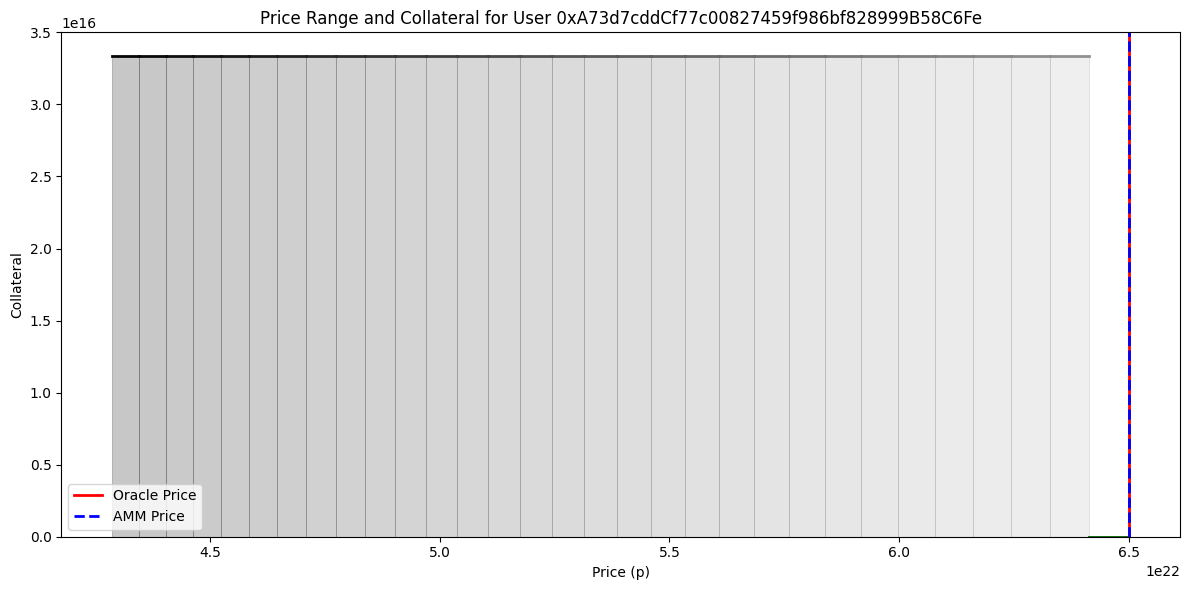

In [8]:
# Supply BORROWER with BTC
wbtc = boa.from_etherscan(WBTC_ADDR, "WBTC", ETHERSCAN_API, ETHERSCAN_KEY)
collateral_amount = 10**8  # 1 BTC
wbtc.transfer(BORROWER, collateral_amount, sender="0x5Ee5bf7ae06D1Be5997A1A72006FE6C607eC6DE8")  # Just use AAVE

# Borrow
max_borrowable = controller.max_borrowable(collateral_amount, 30)
with boa.env.prank(BORROWER):
    wbtc.approve(controller, collateral_amount)
    controller.create_loan(collateral_amount, max_borrowable, 30)

# User bands
plot_user(amm, BORROWER)

## TRADER dumps and trades

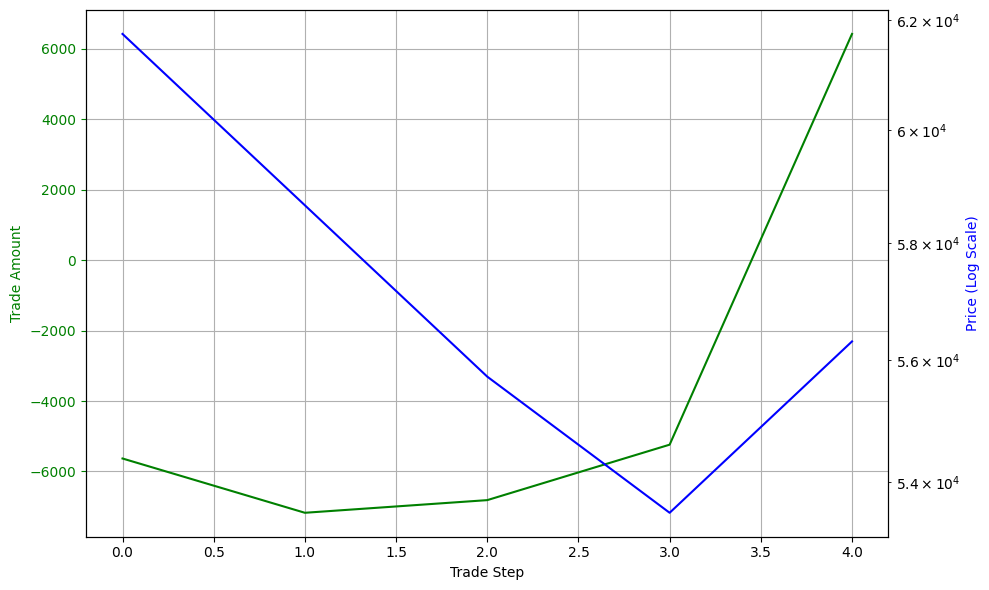

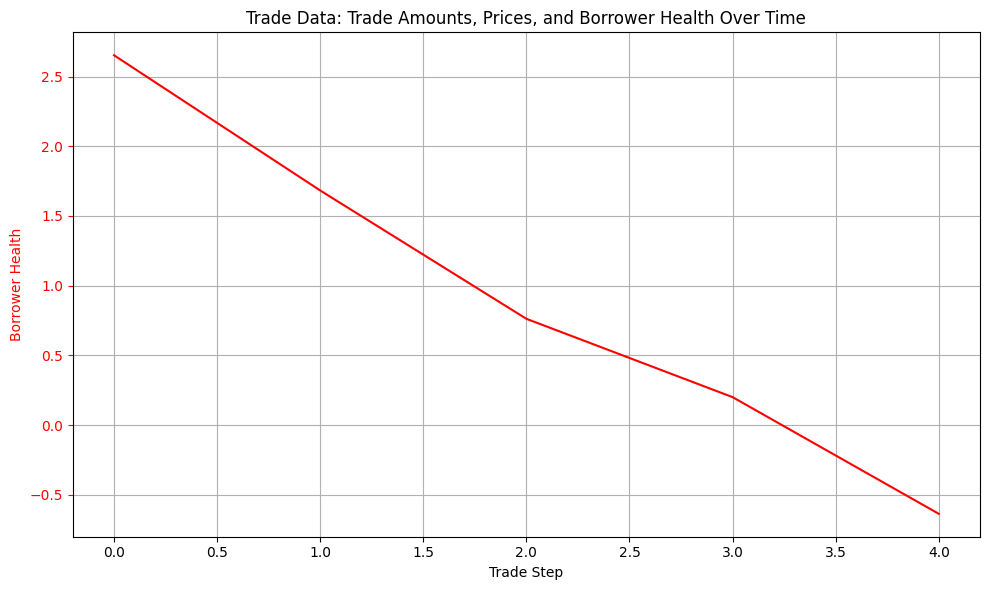

In [9]:
# Fund TRADER and set approvals
crvusd.transfer(TRADER, 100_000 * 10**18, sender="0xA920De414eA4Ab66b97dA1bFE9e6EcA7d4219635")  # crvusd ETH controller
wbtc.transfer(TRADER, 10 * 10**8, sender="0x5Ee5bf7ae06D1Be5997A1A72006FE6C607eC6DE8")  # AAVE

with boa.env.prank(TRADER):
    crvusd.approve(amm, 2**256 - 1)
    wbtc.approve(amm, 2**256 - 1)

# Initialize
[p_up, p_down] = controller.user_prices(BORROWER)
p_mid = (p_up + p_down) // 2
p_o = 65_000 * 10**18
trade_data = []

# The dumping continues to the bottom of BORROWER bands
while controller.health(BORROWER) > 0:
    
    # ADMIN sets oracle price
    if p_o == p_mid:
        p_o = p_o * 20 // 19
    elif p_o * 19 // 20 < p_mid:
        p_o = p_mid
    else:
        p_o = p_o * 19 // 20
    oracle.set_price(p_o, sender=ADMIN)

    # Fast forward
    boa.env.time_travel(seconds=600)

    # TRADER arbs the Llama Lend vault
    trade_amount, is_pump = amm.get_amount_for_price(p_o)
    i = 0  # crvUSD in
    j = 1  # WBTC out
    if not is_pump:
        mult = (p_o / 10 ** 18) / 10 ** wbtc.decimals() 
        i, j = j, i  # WBTC in and crvUSD out
    else:
        mult = -1 / 10 ** 18
    amm.exchange(i, j, trade_amount, 0, sender=TRADER)
    trade_data.append([mult * trade_amount, p_o / 10 ** 18, controller.health(BORROWER) / 10 ** 16])

plot_results(trade_data)

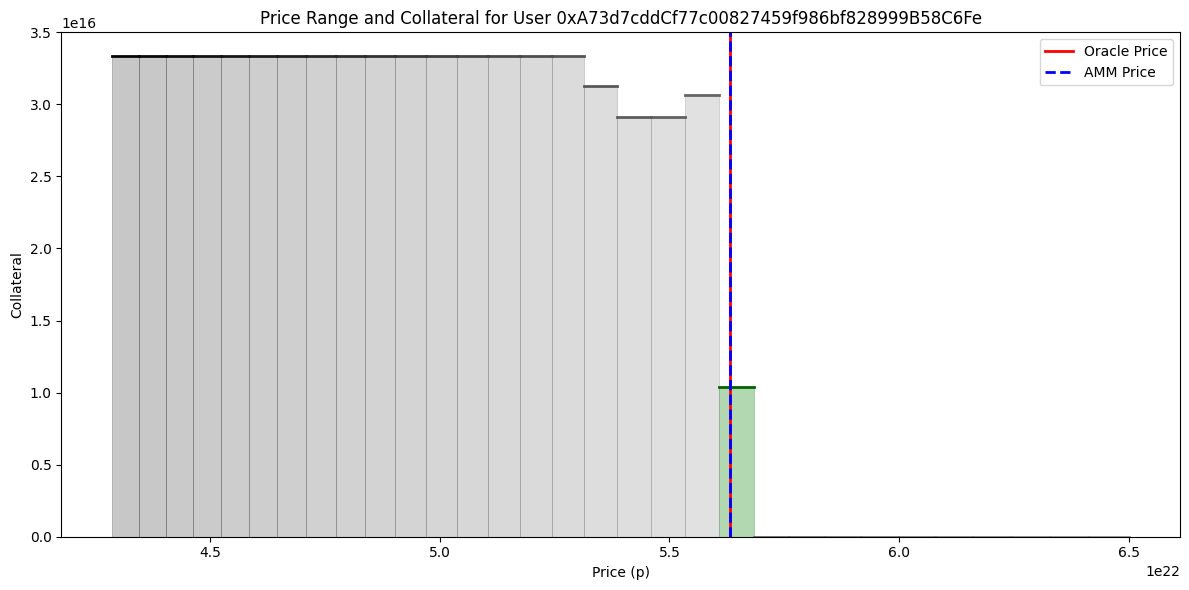

In [10]:
#User collateral state at liquidation time

plot_user(amm, BORROWER)

## LIQUIDATOR runs a partial liquidation

Unhealthy user state: 0.66387642 WBTC, $18,169.19 crvUSD, $49,355.57 debt
Delta: $6,203.02


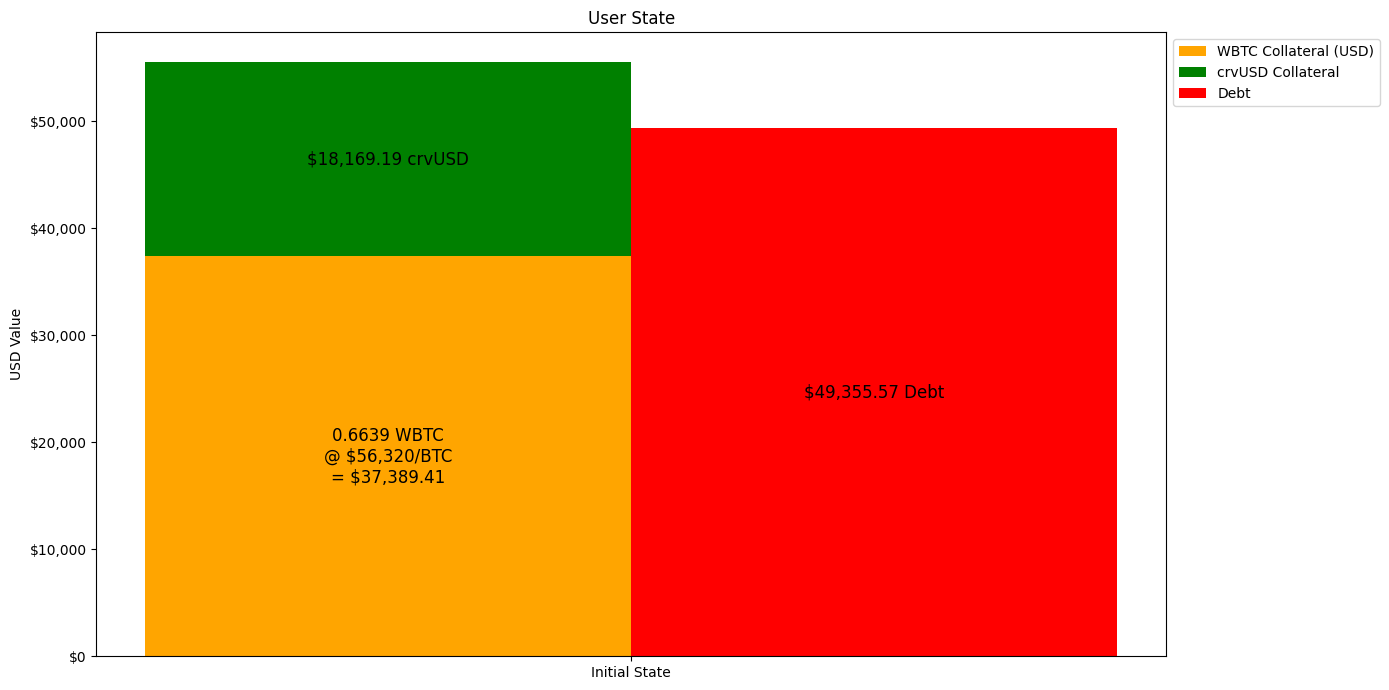

In [11]:
user_state = controller.user_state(BORROWER)

wbtc_collat_init = user_state[0] / 10 ** wbtc.decimals()
crvusd_collat_init = user_state[1] / 10 ** 18
debt_init = user_state[2] / 10 ** 18
wbtc_price = oracle.price_w() / 10 ** 18

print(f"Unhealthy user state: {wbtc_collat_init} WBTC, ${crvusd_collat_init:,.2f} crvUSD, ${debt_init:,.2f} debt")
print(f"Delta: ${wbtc_collat_init * wbtc_price + crvusd_collat_init - debt_init:,.2f}")

plot_user_states([[wbtc_collat_init, crvusd_collat_init, debt_init]], wbtc_price)

In [12]:
%%vyper hard_liquidator_contract
# @version 0.3.10

interface ERC20:
    def transfer(_to: address, _value: uint256) -> bool: nonpayable
    def approve(_spender: address, _value: uint256) -> bool: nonpayable
    def balanceOf(_for: address) -> uint256: view
    def allowance(_owner: address, _spender: address) -> uint256: view

interface OldController:  # Has use_eth arg
    def liquidate_extended(user: address, min_x: uint256, frac: uint256, use_eth: bool, callbacker: address, callback_args: DynArray[uint256,5]): nonpayable

interface Controller:
    def liquidate_extended(user: address, min_x: uint256, frac: uint256, callbacker: address, callback_args: DynArray[uint256,5]): nonpayable
    def collateral_token() -> ERC20: view
    def borrowed_token() -> ERC20: view


ROUTER: immutable(address)

controller: Controller
calldata: Bytes[10**5]


@external
def __init__(_router: address):
    ROUTER = _router


@external
def callback_liquidate(user: address, stablecoins: uint256, collateral: uint256, debt: uint256, callback_args: DynArray[uint256, 5]) -> uint256[2]:
    assert msg.sender == self.controller.address

    collateral_token: ERC20 = self.controller.collateral_token()
    borrowed_token: ERC20 = self.controller.borrowed_token()
    if collateral_token.allowance(self, ROUTER) == 0:
        collateral_token.approve(ROUTER, max_value(uint256), default_return_value=True)
    if borrowed_token.allowance(self, self.controller.address) == 0:
        borrowed_token.approve(self.controller.address, max_value(uint256), default_return_value=True)

    raw_call(ROUTER, self.calldata)
    borrowed_amt: uint256 = borrowed_token.balanceOf(self)

    return [borrowed_amt, 0]


@external
def liquidate(user: address, min_x: uint256, frac: uint256, controller: address, calldata: Bytes[10**5], has_use_eth: bool = False, _for: address = msg.sender) -> uint256[2]:
    self.controller = Controller(controller)
    self.calldata = calldata

    if has_use_eth:
        OldController(self.controller.address).liquidate_extended(user, min_x, frac, False, self, [])
    else:
        self.controller.liquidate_extended(user, min_x, frac, self, [])

    collateral_token: ERC20 = self.controller.collateral_token()
    borrowed_token: ERC20 = self.controller.borrowed_token()
    collateral_amt: uint256 = collateral_token.balanceOf(self)
    borrowed_amt: uint256 = borrowed_token.balanceOf(self)
    if collateral_amt > 0:
        assert collateral_token.transfer(_for, collateral_amt)
    if borrowed_amt > 0:
        assert borrowed_token.transfer(_for, borrowed_amt)

    return [borrowed_amt, collateral_amt]


In [13]:
ROUTER_ADDR = "0x16C6521Dff6baB339122a0FE25a9116693265353"

hard_liquidator = hard_liquidator_contract.deploy(ROUTER_ADDR)

# Liquidate the User 10%

In [14]:
SWAP_DATA = {
    "route": [
        "0x2260fac5e5542a773aa44fbcfedf7c193bc2c599",  # WBTC
        "0xf5f5b97624542d72a9e06f04804bf81baa15e2b4",  # TricryptoUSDT pool
        "0xdac17f958d2ee523a2206206994597c13d831ec7",  # USDT
        "0x390f3595bca2df7d23783dfd126427cceb997bf4",  # crvUSD/USDT pool
        "0xf939e0a03fb07f59a73314e73794be0e57ac1b4e",  # crvUSD
    ] + ["0x0000000000000000000000000000000000000000"] * 6,
    "swap_params": [[1, 0, 1, 30, 3], [0, 1, 1, 1, 2]] + [[0, 0, 0, 0, 0]] * 3,
    "pools": [
         "0xf5f5b97624542d72a9e06f04804bf81baa15e2b4",  # TricryptoUSDT pool
         "0x390f3595bca2df7d23783dfd126427cceb997bf4",  # crvUSD/USDT pool
     ] + ["0x0000000000000000000000000000000000000000"] * 3
}

curve_router = boa.from_etherscan(ROUTER_ADDR, "Router", ETHERSCAN_API, ETHERSCAN_KEY)
tokens_to_liquidate = user_state[2] - user_state[1]
print(f"Tokens to liquidate: {tokens_to_liquidate / 10**18} crvUSD")

wbtc_required = curve_router.get_dx(SWAP_DATA["route"], SWAP_DATA["swap_params"],  tokens_to_liquidate, SWAP_DATA["pools"])
print(f"WBTC required: {wbtc_required / 10**wbtc.decimals()} WBTC")

Tokens to liquidate: 31186.386107017854 crvUSD
WBTC required: 0.32735616 WBTC


In [15]:
frac = 0.1
h = controller.liquidation_discounts(BORROWER) / 10 ** 18
f_remove = ((1 + h / 2) / (1 + h) * (1 - frac) + frac) * frac  

print(f"In case of partial liquidation we get less collateral and thus increase user's health.\n"
      f"In this example we get {f_remove * 100} % of collateral and borrowed assets "
      f"from user's position, but have to repay {frac * 100} % of debt")

In case of partial liquidation we get less collateral and thus increase user's health.
In this example we get 9.847826086956523 % of collateral and borrowed assets from user's position, but have to repay 10.0 % of debt


In [16]:
formula = r'f_{\text{remove}} = \left( \frac{1 + \frac{h}{2}}{1 + h} \cdot (1 - \text{frac}) + \text{frac} \right) \cdot \text{frac}'
display(Math(formula))

<IPython.core.display.Math object>

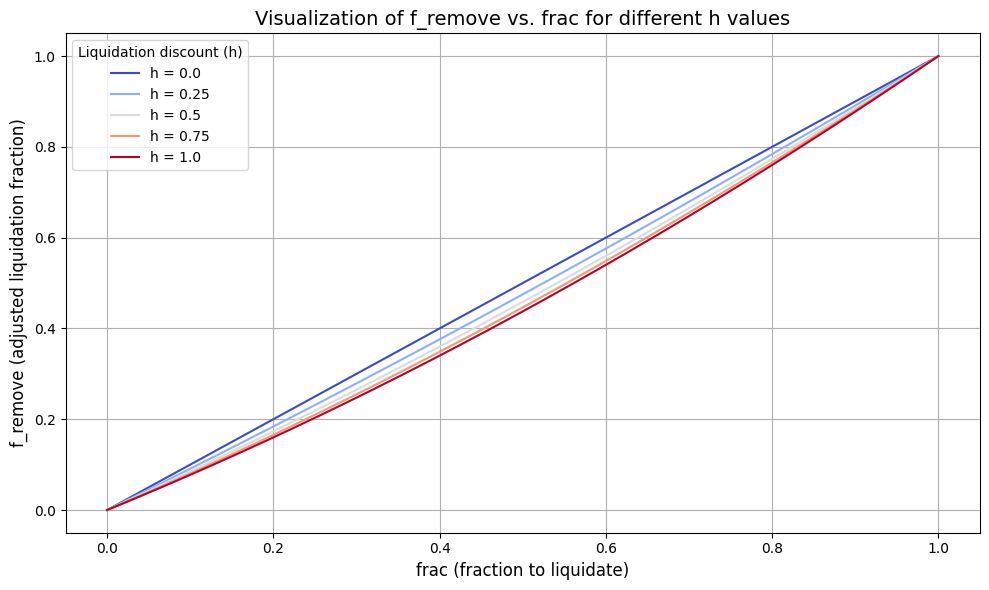

In [17]:
def f_remove_calc(frac, h):
    return ((1 + h / 2) / (1 + h) * (1 - frac) + frac) * frac

frac_values = np.linspace(0, 1, 500)  # 500 points from 0 to 1
h_values = np.linspace(0,1,5)

cmap = matplotlib.colormaps["coolwarm"]
colors = cmap(np.linspace(0, 1, len(h_values)))

# Plot
plt.figure(figsize=(10, 6))
for i, h in enumerate(h_values):
    f_values = f_remove_calc(frac_values, h)
    plt.plot(frac_values, f_values, label=f"h = {h}", color=colors[i])

plt.title("Visualization of f_remove vs. frac for different h values", fontsize=14)
plt.xlabel("frac (fraction to liquidate)", fontsize=12)
plt.ylabel("f_remove (adjusted liquidation fraction)", fontsize=12)
plt.grid(True)
plt.legend(title="Liquidation discount (h)", fontsize=10)
plt.tight_layout()

plt.show()

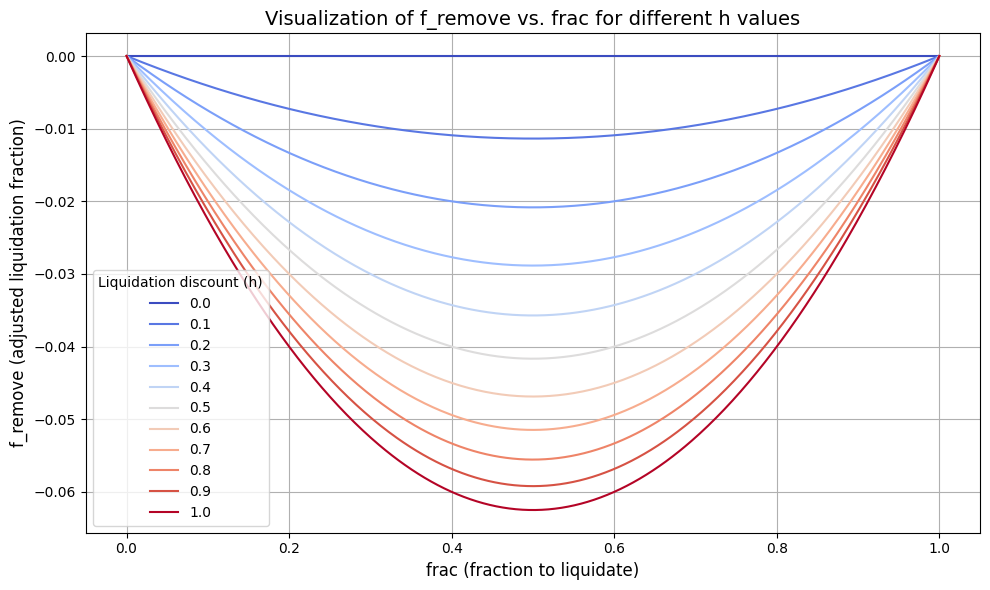

In [18]:
h_values = np.linspace(0,1,11)
colors = cmap(np.linspace(0, 1, len(h_values)))

# Plot
f_0 = f_remove_calc(frac_values, 0)
plt.figure(figsize=(10, 6))
for i, h in enumerate(h_values):
    f_values = f_remove_calc(frac_values, h) - f_0
    plt.plot(frac_values, f_values, label=f"{h:.1f}", color=colors[i])

plt.title("Visualization of f_remove vs. frac for different h values", fontsize=14)
plt.xlabel("frac (fraction to liquidate)", fontsize=12)
plt.ylabel("f_remove (adjusted liquidation fraction)", fontsize=12)
plt.grid(True)
plt.legend(title="Liquidation discount (h)", fontsize=10)
plt.tight_layout()

plt.show()


In [19]:
wbtc_to_sell = int(user_state[0] * f_remove)
print(f"WBTC to sell: {wbtc_to_sell / 10 ** wbtc.decimals()} WBTC ({wbtc_to_sell / user_state[0] * 100}%)")

WBTC to sell: 0.06537739 WBTC (9.847825292544659%)


In [20]:
# Perform liquidation
print(f"Liquidator initial balances: {wbtc.balanceOf(LIQUIDATOR)} WBTC, {crvusd.balanceOf(LIQUIDATOR)} crvUSD")

expected = curve_router.get_dy(SWAP_DATA["route"], SWAP_DATA["swap_params"], wbtc_to_sell)
calldata = curve_router.exchange.prepare_calldata(SWAP_DATA["route"], SWAP_DATA["swap_params"], wbtc_to_sell, expected * 999 // 1000)
hard_liquidator.liquidate(BORROWER, int(user_state[1] * f_remove) * 999 // 1000, 10**17, controller, calldata, sender=LIQUIDATOR)
print("\nPARTIAL LIQUIDATION HAPPENED!!!\n")

final_wbtc = wbtc.balanceOf(LIQUIDATOR) / 10 ** wbtc.decimals()
final_crvusd = crvusd.balanceOf(LIQUIDATOR) / 10 ** crvusd.decimals()

print(f"Liquidator final balances: {final_wbtc} WBTC, ${final_crvusd:,.2f} crvUSD")
print(f"Liquidator value: ${final_wbtc * wbtc_price + final_crvusd:,.2f}")

Liquidator initial balances: 0 WBTC, 0 crvUSD

PARTIAL LIQUIDATION HAPPENED!!!

Liquidator final balances: 0.0 WBTC, $3,104.61 crvUSD
Liquidator value: $3,104.61


Initial user state: 0.66387642 WBTC, 18169.188362578265 crvUSD, 49355.57446959612 debt
Liquidated user state: 0.59849903 WBTC, 16379.918291220016 crvUSD, 44420.01702263651 debt


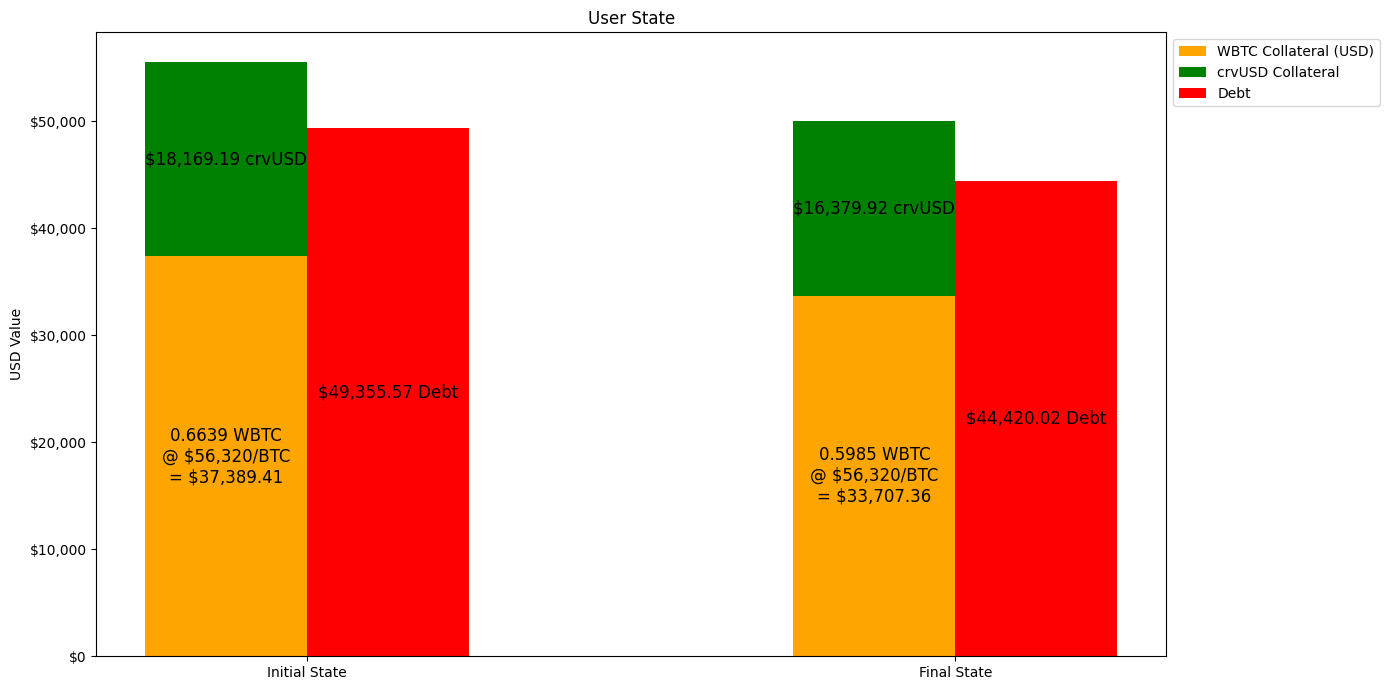

In [21]:
# User loan is not cleared after liquidation
final_user_state = controller.user_state(BORROWER)

wbtc_collat_final = final_user_state[0] / 10 ** wbtc.decimals()
crvusd_collat_final = final_user_state[1] / 10 ** 18
debt_final = final_user_state[2] / 10 ** 18

print(f"Initial user state: {wbtc_collat_init} WBTC, {crvusd_collat_init} crvUSD, {debt_init} debt")
print(f"Liquidated user state: {wbtc_collat_final} WBTC, {crvusd_collat_final} crvUSD, {debt_final} debt")

plot_user_states([
    [wbtc_collat_init, crvusd_collat_init, debt_init],
    [wbtc_collat_final, crvusd_collat_final, debt_final],
                 ], wbtc_price)